Gold rows: 112880


date,location_id,country,latitude,longitude,pm10_avg,pm25_avg,pm10_count,pm25_count,sensors,measurements
2026-01-16,49,DE,48.53,9.2,16.13,59.629999999999995,1,2,2,3
2026-01-16,65,DE,48.778,9.16,0.0,0.0,1,1,1,2
2026-01-16,45999,DE,48.808,9.182,0.36,0.36,1,1,1,2
2026-01-16,68,DE,48.792,9.164,13.12,6.61,1,1,1,2
2026-01-16,3946,DE,48.958,8.284,1.95,1.64,1,1,1,2
2026-01-16,78,DE,48.788,9.01,15.14,2.8,1,1,1,2
2026-01-16,55473,DE,48.8,9.002,2.0,1.95,1,1,1,2
2026-01-16,90,DE,48.81,9.12,8.08,3.66,1,1,1,2
2026-01-16,104,DE,53.59,10.004,57.0,24.06,1,1,1,2
2026-01-16,109,DO,19.806,-70.704,24.82,22.04,1,1,1,2


Latest date: 2026-02-03
Suspicious PM2.5 / PM10 ratios: 0


<bound method NDFrame.head of Empty DataFrame
Columns: [location_id, pm10_avg, pm25_avg, pm_ratio]
Index: []>

Detected 81 PM10 anomalies
Detected 67 PM2.5 anomalies


location_id,pm10_avg,pm25_avg,pm_ratio,pm10_zscore,pm25_zscore
1014,427.55999999999995,104.74333333333334,0.24497926216983196,11.221241890753783,4.219595798285148
1830,725.9166666666666,433.2,0.5967627138101251,19.568281395006483,19.540999234443117
3145,679.2566666666667,407.9666666666667,0.600607526855337,18.26288786175736,18.363948745675287
16392,116.47333333333331,96.3,0.826798694980253,2.518058801454762,3.825742576614221
5692,299.99666666666667,285.6466666666667,0.9521661351792798,7.652438838609855,12.65813041861791
5754,178.2833333333333,170.50333333333333,0.9563615967093579,4.247299570638823,7.287079555539017
6687,461.49666666666667,420.4166666666667,0.910985272555237,12.17067835039154,18.944699548257564
32542,357.2833333333333,204.03,0.5710593833092318,9.255131599177037,8.850986268356303
9219,569.5,82.82000000000001,0.14542581211589115,15.192256852377886,3.196945723697826
10115,306.09999999999997,288.76666666666665,0.9433736251769574,7.823190057311038,12.80366796914455



Logging quality metrics / anomalies:
Quality metrics / anomalies:{'date': '2026-02-03', 'locations_checked': 10285, 'pm10_anomalies': 81, 'pm25_anomalies': 67, 'ratio_violations': 0}



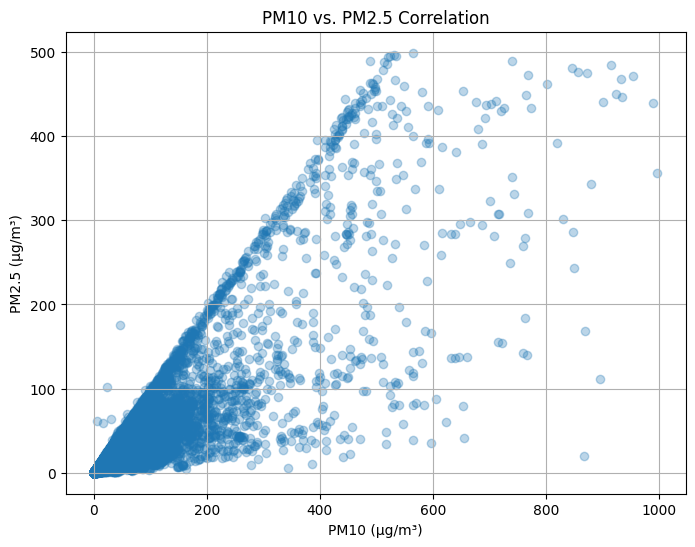

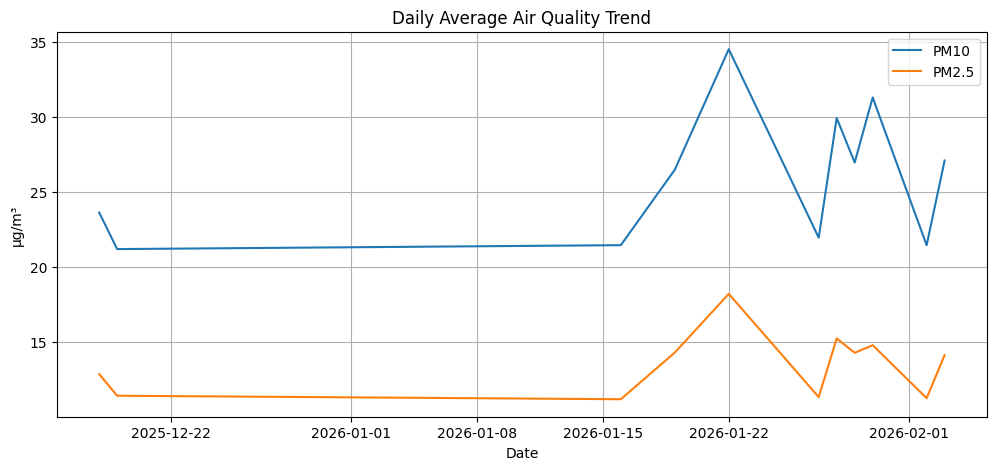

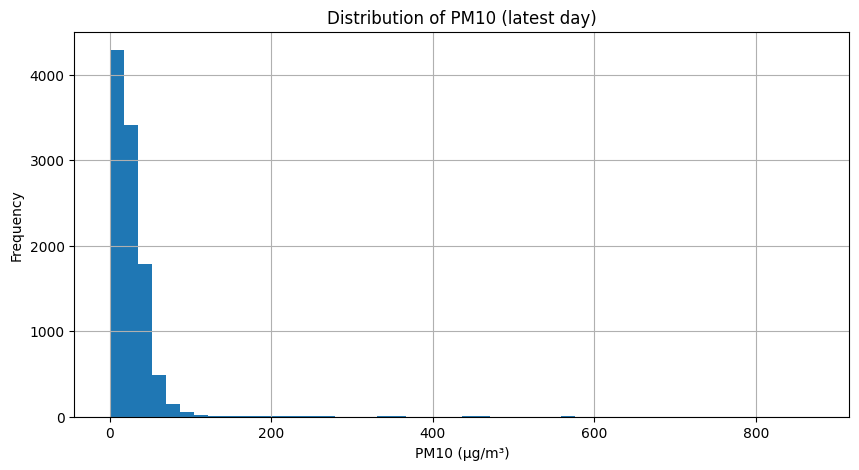

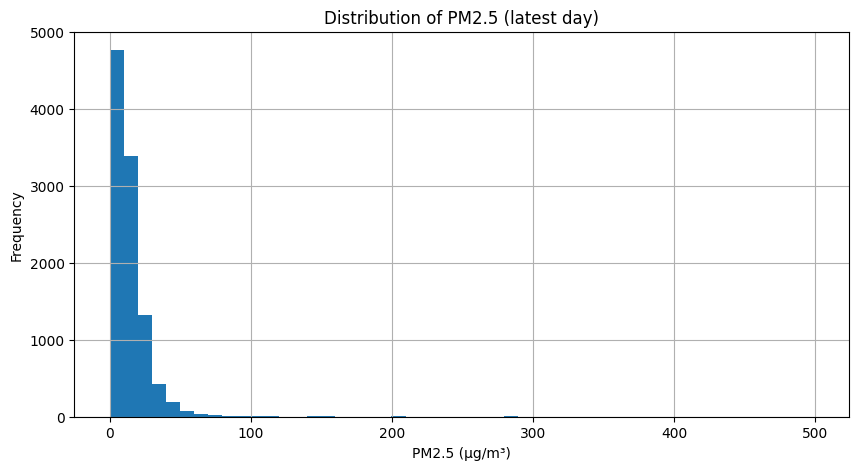

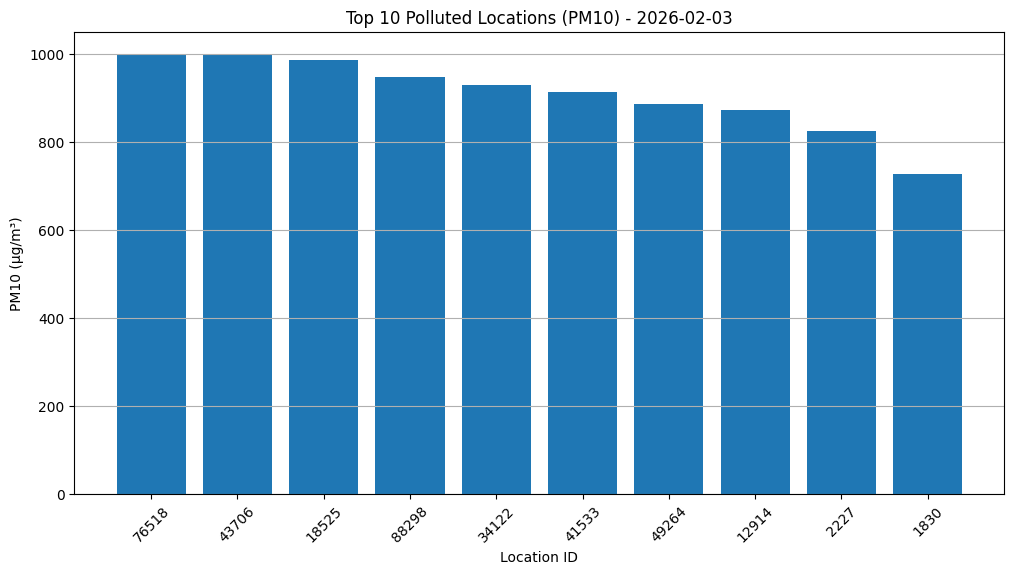

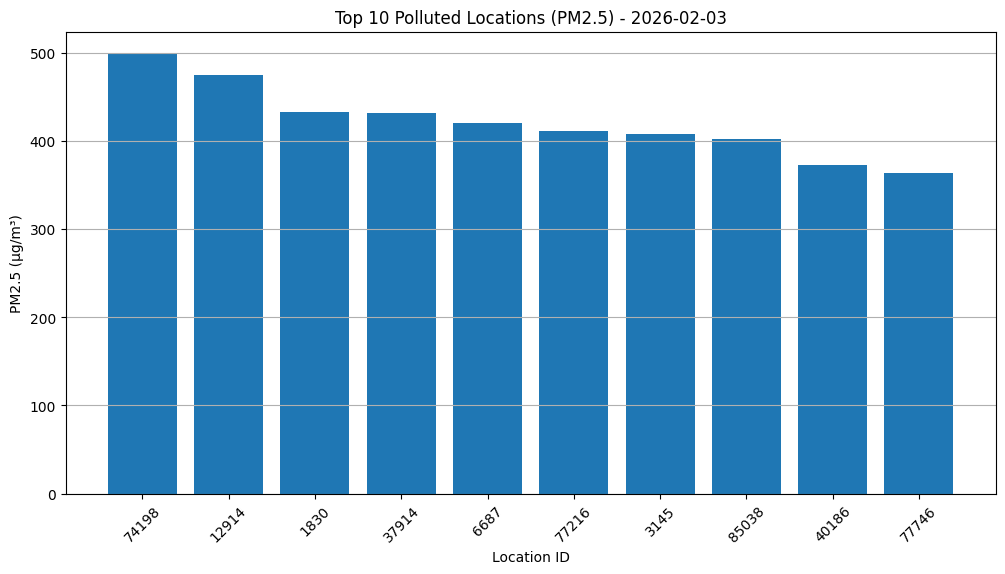

In [0]:
"""
05_visualization.ipynb

Purpose:
- Visualize Gold air quality data
- Demonstrate analytical value of the pipeline
- Read-only consumption of Gold tables

NOTE:
This notebook is for data quality validation and exploratory analysis.
It does NOT represent real-time air quality. It provides exploratory, ad-hoc, and quality-focused analysis
to validate Gold layer correctness (data quality, statistical sanity, and behavioral validation).
"""

# Databricks notebooks do not automatically include the project root in PYTHONPATH.
# To enable imports from src/, each notebook adds the project root to sys.path at runtime
import sys, os
sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import (
    col,
    avg
)

# Read Gold table for python sanity checks
gold_df_python = spark.read.table("air_quality_gold.daily_air_quality")

print(f"Gold rows: {gold_df_python.count()}")
display(gold_df_python.limit(10))

# Get latest day
latest_date = (
    gold_df_python
    .selectExpr("max(date) as max_date")
    .collect()[0]["max_date"]
)
print("Latest date:", latest_date)

# Focus on latest date
latest_df = (
    gold_df_python
    .filter(col("date") == latest_date)
)

pdf = latest_df.select(
    "location_id",
    "pm10_avg",
    "pm25_avg"
).dropna().toPandas()

# Calculation - Ratio between PM2.5 and PM10 sanity check (physical plausibility)
# Physically PM2.5 ⊆ PM10
# PM2.5 ≫ PM10 is suspicious
# Guard against division by zero
pdf = pdf[pdf["pm10_avg"] > 0]

# Calculate PM2.5 / PM10 ratio
pdf["pm_ratio"] = pdf["pm25_avg"] / pdf["pm10_avg"]
suspicious_ratio = pdf[pdf["pm_ratio"] > 1.2]

print(f"Suspicious PM2.5 / PM10 ratios: {len(suspicious_ratio)}")
display(suspicious_ratio.head)

# Visualization - Detect unusually high PM10 and PM2.5 values (z-score outlier detection / broken parsing)
# Define z-score threshold
Z_THRESHOLD = 3

# Calculate Z-score for PM10
pm10_mean = pdf["pm10_avg"].mean()
pm10_std = pdf["pm10_avg"].std()

pdf["pm10_zscore"] = (pdf["pm10_avg"] - pm10_mean) / pm10_std

# Flag anomalies (e.g. > 3 standard deviations)
anomalies_pm10 = pdf[pdf["pm10_zscore"].abs() > Z_THRESHOLD]

print(f"Detected {len(anomalies_pm10)} PM10 anomalies")

# Calculate Z-score for PM2.5
pm25_mean = pdf["pm25_avg"].mean()
pm25_std = pdf["pm25_avg"].std()

pdf["pm25_zscore"] = (pdf["pm25_avg"] - pm25_mean) / pm25_std

# Flag anomalies (e.g. > 3 standard deviations)
anomalies_pm25 = pdf[pdf["pm25_zscore"].abs() > Z_THRESHOLD]

print(f"Detected {len(anomalies_pm25)} PM2.5 anomalies")
display(anomalies_pm25.head(10))

if pm10_std == 0 or np.isnan(pm10_std):
    print("Warning: PM10 standard deviation undefined")

# Logging quality metrics / anomalies
# NOTE: Anomalies here do not imply bad air quality, only potential data issues
print("\nLogging quality metrics / anomalies:")

quality_metrics = {    
                   "date": str(latest_date),
    "locations_checked": len(pdf),
    "pm10_anomalies": len(anomalies_pm10),
    "pm25_anomalies": len(anomalies_pm25),
    "ratio_violations": len(suspicious_ratio)
}

print(f"Quality metrics / anomalies:{quality_metrics}\n")

# Visualization - Correlation between PM10 and PM2.5 (structural correlation)
scatter_pdf = (
    gold_df_python
    .select("pm10_avg", "pm25_avg")
    .dropna()
    .toPandas()
)

# Plot scatter plot
plt.figure(figsize=(8, 6))

plt.scatter(
    scatter_pdf["pm10_avg"],
    scatter_pdf["pm25_avg"],
    alpha=0.3
)

plt.title("PM10 vs. PM2.5 Correlation")
plt.xlabel("PM10 (µg/m³)")
plt.ylabel("PM2.5 (µg/m³)")
plt.grid(True)
plt.show()

# Visualization - Time stability check (stability across runs)
time_pdf = (
    gold_df_python
    .groupBy("date")
    .agg(
        avg("pm10_avg").alias("avg_pm10"),
        avg("pm25_avg").alias("avg_pm25")
    )
    .orderBy("date")
    .toPandas()
)

plt.figure(figsize=(12, 5))
plt.plot(time_pdf["date"], time_pdf["avg_pm10"], label="PM10")
plt.plot(time_pdf["date"], time_pdf["avg_pm25"], label="PM2.5")
plt.legend()
plt.title("Daily Average Air Quality Trend")
plt.xlabel("Date")
plt.ylabel("µg/m³")
plt.grid(True)
plt.show()

# Visualization - Distribution histogram plots (catching bad ingestion / distribution sanity)
# Distribution of PM10
plt.figure(figsize=(10, 5))
plt.hist(pdf["pm10_avg"], bins=50)
plt.title("Distribution of PM10 (latest day)")
plt.xlabel("PM10 (µg/m³)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Distribution of PM2.5
plt.figure(figsize=(10, 5))
plt.hist(pdf["pm25_avg"], bins=50)
plt.title("Distribution of PM2.5 (latest day)")
plt.xlabel("PM2.5 (µg/m³)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Visualization - Top 10 most polluted locations (ranking logic correctness)
# Top locations by PM10
top_locations_df_pm10 = (
    gold_df_python
    .filter(gold_df_python.date == latest_date)
    .orderBy(gold_df_python.pm10_avg.desc())
    .limit(10)
)

top_locations_pdf_pm10 = top_locations_df_pm10.toPandas()

# Plot bar chart
plt.figure(figsize=(12, 6))

plt.bar(
    top_locations_pdf_pm10["location_id"].astype(str),
    top_locations_pdf_pm10["pm10_avg"]
)

plt.title(f"Top 10 Polluted Locations (PM10) - {latest_date}")
plt.xlabel("Location ID")
plt.ylabel("PM10 (µg/m³)")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()

# Top locations by PM2.5
top_locations_df_pm25 = (
    gold_df_python
    .filter(gold_df_python.date == latest_date)
    .orderBy(gold_df_python.pm25_avg.desc())
    .limit(10)
)

top_locations_pdf_pm25 = top_locations_df_pm25.toPandas()

# Plot bar chart
plt.figure(figsize=(12, 6))

plt.bar(
    top_locations_pdf_pm25["location_id"].astype(str),
    top_locations_pdf_pm25["pm25_avg"]
)

plt.title(f"Top 10 Polluted Locations (PM2.5) - {latest_date}")
plt.xlabel("Location ID")
plt.ylabel("PM2.5 (µg/m³)")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()

dbutils.notebook.exit(
    f"Gold Quality Checks: visualization sanity checks completed"
)